# Preprocessing

In [1]:
# Import needed libraries
import os
from pathlib import Path

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import png
from IPython.display import display
from matplotlib import animation, rc
from pydicom import dcmread
from skimage.transform import resize


# Set row limit to display to none.
pd.set_option("max_row", None)
# Set column limit to display to none.
pd.set_option("max_columns", None)
# Set column width to none.
pd.set_option("max_colwidth", 150)
# Set runtime configuration for animation to use jshtml.
rc("animation", html="jshtml")

display(pd.options.display.max_rows)
display(pd.options.display.max_columns)
display(pd.options.display.max_colwidth)

None

None

150

In [2]:
# Get project folder path for notebook
PROJECT_FOLDER = str(Path.cwd().parent.parent)
DATA_PATH = PROJECT_FOLDER + "/data/original_rembrandt/"
DATASET_PATH = DATA_PATH + "dataset/"
DATA_DESCRIPTION_FILE = "clinical_2014-01-16.xlsx"
LABELS_FILE = "labels.csv"
FILENAME_FILE = "filenames.csv"
VALID_SAMPLES_FILE = "valid_samples.csv"
VALID_SAMPLES_REDUCED_FILE = "valid_samples_reduced.csv"

print("Project folder: " + PROJECT_FOLDER)
print("Data path: " + DATA_PATH)
print("Dataset path: " + DATASET_PATH)
print("Data description file: " + DATA_DESCRIPTION_FILE)
print("Labels file: " + LABELS_FILE)
print("Filenames file: " + FILENAME_FILE)
print("Valid samples file: " + VALID_SAMPLES_FILE)
print("Valid samples reduced file: " + VALID_SAMPLES_REDUCED_FILE)

Project folder: /Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info
Data path: /Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/original_rembrandt/
Dataset path: /Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/original_rembrandt/dataset/
Data description file: clinical_2014-01-16.xlsx
Labels file: labels.csv
Filenames file: filenames.csv
Valid samples file: valid_samples.csv
Valid samples reduced file: valid_samples_reduced.csv


## Define helper functions

In [3]:
def get_current_info(df, col, reset=False, head=5, tail=None):
    if reset:
        # Reset index.
        df.reset_index(drop=True, inplace=True)

    values = [str(v) for v in df[col].unique()]
    spaces = " " * len(max(list(values), key=len))

    if tail is None:
        display(df.head(head))
    else:
        display(df.tail(tail))
    print("Shape:", df.shape)
    print(f"NaN {spaces}{df[col].isnull().sum()}")
    display(df[col].value_counts())


# Check if file exists in current directory
def check_file_exists(file_name):
    if os.path.isfile(file_name):
        print(f"{file_name} exists")
        return True
    else:
        print(f"{file_name} does not exist")
        return False


def create_animation(ims):
    ims = ims
    # fps = 30
    # nSeconds = 5
    fig = plt.figure(figsize=(8, 8))
    a = ims[0]
    im = plt.imshow(a, cmap=plt.cm.gray)

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    anim = animation.FuncAnimation(
        fig, animate_func, frames=len(ims), interval=1000 // 15
    )

    return anim

## Reading and initial processing of data

In [4]:
df_labels = pd.read_excel(  # Read specific columns of excel file.
    (DATA_PATH + DATA_DESCRIPTION_FILE),
    usecols=["Sample", " Disease", " Grade"],
).rename(  # Rename columns.
    columns={"Sample": "sample", " Disease": "disease", " Grade": "grade"}
)

# Remove leading whitespace in all cells.
df_labels = df_labels.apply(
    lambda x: x.str.strip() if x.dtype == "object" else x
)

# Replace "--"" with np.nan.
df_labels.replace("--", np.nan, inplace=True)

# Add label column
df_labels["label"] = np.nan

# # in column sample change "-" to "_"
df_labels["sample"] = df_labels["sample"].str.replace("_", "-")

# Make disease names lowercase.
df_labels["disease"] = df_labels["disease"].str.lower()

# Set grade for GBM disease to to "IV"
df_labels.loc[df_labels['disease'] == "gbm", 'grade'] = "IV"

In [5]:
get_current_info(df=df_labels, col="disease", head=10)

,sample,disease,grade,label
0,900-00-1961,astrocytoma,II,NaN
1,900-00-5332,gbm,IV,NaN
2,900-00-5308,astrocytoma,III,NaN
3,900-00-5316,gbm,IV,NaN
4,900-00-5317,gbm,IV,NaN
5,900-00-5338,gbm,IV,NaN
6,900-00-5339,gbm,IV,NaN
7,900-00-5341,oligodendroglioma,NaN,NaN
8,900-00-5342,gbm,IV,NaN
9,900-00-5345,oligodendroglioma,II,NaN


Shape: (127, 4)
NaN                  15


astrocytoma          47
gbm                  43
oligodendroglioma    21
mixed                 1
Name: disease, dtype: int64

## Filter out valid data.

Drop rows with mixed disease.

In [6]:
# Find all samples with missing disease.
df_labels[df_labels["disease"] == "mixed"]

,sample,disease,grade,label
54,HF1059,mixed,III,NaN


In [7]:
# Drop rows with mixed disease.
df_labels = df_labels[df_labels["disease"] != "mixed"].reset_index(drop=True)

Set rows with missing disease and grade to none, in other words, healthy.

In [8]:
# Get all NaN diseases and NaN grade in dataframe.
df_labels[(df_labels["disease"].isnull()) & (df_labels["grade"].isnull())]

,sample,disease,grade,label
34,HF0763,NaN,NaN,NaN
38,HF0868,NaN,NaN,NaN
39,HF0883,NaN,NaN,NaN
58,HF1113,NaN,NaN,NaN
68,HF1199,NaN,NaN,NaN
70,HF1226,NaN,NaN,NaN
80,HF1293,NaN,NaN,NaN
82,HF1300,NaN,NaN,NaN
83,HF1307,NaN,NaN,NaN
86,HF1331,NaN,NaN,NaN


In [9]:
# Set df_labesl "disease", "grade" and "label" to "none" where disease is "NaN" and grade is "NaN".
df_labels.loc[
    (df_labels["disease"].isnull()) & (df_labels["grade"].isnull()),
    ["disease", "grade", "label"]
] = "none"

Look for NaN values in the data.

In [10]:
get_current_info(df=df_labels, col="grade", reset=True, head=10)

,sample,disease,grade,label
0,900-00-1961,astrocytoma,II,NaN
1,900-00-5332,gbm,IV,NaN
2,900-00-5308,astrocytoma,III,NaN
3,900-00-5316,gbm,IV,NaN
4,900-00-5317,gbm,IV,NaN
5,900-00-5338,gbm,IV,NaN
6,900-00-5339,gbm,IV,NaN
7,900-00-5341,oligodendroglioma,NaN,NaN
8,900-00-5342,gbm,IV,NaN
9,900-00-5345,oligodendroglioma,II,NaN


Shape: (126, 4)
NaN     3


IV      43
II      41
III     24
none    15
Name: grade, dtype: int64

In [11]:
df_labels[df_labels["grade"].isnull()]

,sample,disease,grade,label
7,900-00-5341,oligodendroglioma,NaN,NaN
12,900-00-5380,oligodendroglioma,NaN,NaN
20,900-00-5412,oligodendroglioma,NaN,NaN


Oligodendroglioma can be graded as "II" or "III". When grade is NaN, they cannot be used.

In [12]:
# Drop rows with NaN grade.
df_labels.dropna(subset=['grade'], inplace=True)

Verify that the data does not contain any NaN values.

In [13]:
get_current_info(df=df_labels, col="grade", reset=True, head=10)

,sample,disease,grade,label
0,900-00-1961,astrocytoma,II,NaN
1,900-00-5332,gbm,IV,NaN
2,900-00-5308,astrocytoma,III,NaN
3,900-00-5316,gbm,IV,NaN
4,900-00-5317,gbm,IV,NaN
5,900-00-5338,gbm,IV,NaN
6,900-00-5339,gbm,IV,NaN
7,900-00-5342,gbm,IV,NaN
8,900-00-5345,oligodendroglioma,II,NaN
9,900-00-5346,gbm,IV,NaN


Shape: (123, 4)
NaN     0


IV      43
II      41
III     24
none    15
Name: grade, dtype: int64

Get all the diseases, grades and their counts.

In [14]:
df_labels.groupby(["disease", "grade"]).agg({"sample": "nunique"}).reset_index()

,disease,grade,sample
0,astrocytoma,II,30
1,astrocytoma,III,17
2,gbm,IV,43
3,none,none,15
4,oligodendroglioma,II,11
5,oligodendroglioma,III,7


Set labels for disease and grade

In [15]:
# if disease is "GBM" label is "hgg"
df_labels.loc[
    (df_labels["disease"] == "gbm") & (df_labels["grade"] == "IV"), "label"
] = "hgg"
# if "disease" is ("oligodendroglioma" or "astrocytoma" and grade is "II")
# set label to "lgg". Else if "disease" is "GBM" or
# "oligodendroglioma" or "astrocytoma" and grade is "III"
df_labels.loc[
    (df_labels["disease"].isin(["oligodendroglioma", "astrocytoma"]))
    & (df_labels["grade"].isin(["II"])),
    "label",
] = "lgg"
df_labels.loc[
    (df_labels["disease"].isin(["oligodendroglioma", "astrocytoma"]))
    & (df_labels["grade"].isin(["III"])),
    "label",
] = "hgg"
# if disease is "NaN" label is "normal"
df_labels.loc[df_labels["disease"] == "none", "label"] = "none"
# # if disease is "GBM" grade is "IV"
# df_labels.loc[df_labels['disease'].isin(["GBM"]), 'grade'] = 'IV'


Get all the diseases, grades, labels and their counts.

In [16]:
df_labels.groupby(["disease", "grade", "label"]).agg({"sample": "nunique"}).reset_index()

,disease,grade,label,sample
0,astrocytoma,II,lgg,30
1,astrocytoma,III,hgg,17
2,gbm,IV,hgg,43
3,none,none,none,15
4,oligodendroglioma,II,lgg,11
5,oligodendroglioma,III,hgg,7


Look for differences between supplied information and the dataset. Here, if a sample contains a decimal point that is not present in the dataset folder.

In [17]:
# Find any samples that are floats
df_labels.loc[df_labels['sample'].astype(str).str.contains("\.") == True]

,sample,disease,grade,label
30,HF0652.4,gbm,IV,hgg


Remove the decimal point from the sample name.

In [18]:
# for every sample in df_labels["sample"] if "sample" has "." remove "." and all char after "."
df_labels["sample"] = df_labels["sample"].apply(
    lambda x: x.split(".")[0] if "." in x else x
)

Verify that the decimal point is removed from the sample name.

In [19]:
df_labels[df_labels["sample"].str.startswith("HF065")]

,sample,disease,grade,label
30,HF0652,gbm,IV,hgg


In [20]:
df_labels.loc[df_labels['sample'].astype(str).str.contains("\.") == True]

,sample,disease,grade,label


Write the labeled samples to a csv file.

In [21]:
# Write to csv
if not check_file_exists(DATA_PATH + LABELS_FILE):
    df_labels.to_csv(DATA_PATH + LABELS_FILE, index=False)

/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/original_rembrandt/labels.csv exists


## Generate file paths for all samples

In [22]:
# define pandas dataframe from the folderstructure of the dataset.
if not check_file_exists(DATA_PATH + FILENAME_FILE):
    df_files = pd.DataFrame(
        columns=[
            "sample",
            "sample_L1",
            "sample_L2",
            "file_name",
            "relative_path",
        ]
    )

    for full_path, dirs, files in os.walk(DATASET_PATH):
        full_path = Path(full_path)
        for file in files:
            if file.endswith(".dcm"):
                relative = full_path.relative_to(DATASET_PATH).parts
                df_files = df_files.append(
                    {
                        "sample": relative[0],
                        "sample_L1": relative[1],
                        "sample_L2": relative[2],
                        "file_name": file,
                        # join relative path with file name
                        "relative_path": full_path.relative_to(
                            DATASET_PATH
                        ).joinpath(file),
                    },
                    ignore_index=True,
                )

    df_files.sort_values(
        by=["sample", "sample_L1", "sample_L2", "file_name"], inplace=True
    )
    # Write to csv
    df_files.to_csv(DATA_PATH + FILENAME_FILE, index=False)

else:
    df_files = pd.read_csv(DATA_PATH + FILENAME_FILE)

/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/original_rembrandt/filenames.csv exists


In [23]:
display(df_files.shape)
df_files.head()

(110020, 5)

,sample,sample_L1,sample_L2,file_name,relative_path
0,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-1.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-1.dcm
1,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-2.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-2.dcm
2,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-3.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-3.dcm
3,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-01.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-01.dcm
4,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-02.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-02.dcm


## Merge applicable samples with their respective files

In [24]:
df = df_files.merge(df_labels, on="sample", how="left").reset_index(drop=True)

In [25]:
df.head()

,sample,sample_L1,sample_L2,file_name,relative_path,disease,grade,label
0,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-1.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-1.dcm,astrocytoma,II,lgg
1,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-2.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-2.dcm,astrocytoma,II,lgg
2,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-3.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-3.dcm,astrocytoma,II,lgg
3,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-01.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-01.dcm,astrocytoma,II,lgg
4,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-02.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-02.dcm,astrocytoma,II,lgg


Check equality of df_labels and merged df.

In [26]:
df_labels.groupby(["label"]).agg({"sample": "nunique"}).reset_index()

,label,sample
0,hgg,67
1,lgg,41
2,none,15


In [27]:
df.groupby(["label"]).agg({"sample": "nunique"}).reset_index()

,label,sample
0,hgg,67
1,lgg,41
2,none,15


In [28]:
df_labels.groupby(["disease", "grade", "label"]).agg(
    {"sample": "nunique"}
).reset_index()

,disease,grade,label,sample
0,astrocytoma,II,lgg,30
1,astrocytoma,III,hgg,17
2,gbm,IV,hgg,43
3,none,none,none,15
4,oligodendroglioma,II,lgg,11
5,oligodendroglioma,III,hgg,7


In [29]:
df.groupby(["disease", "grade", "label"]).agg(
    {"sample": "nunique"}
).reset_index()

,disease,grade,label,sample
0,astrocytoma,II,lgg,30
1,astrocytoma,III,hgg,17
2,gbm,IV,hgg,43
3,none,none,none,15
4,oligodendroglioma,II,lgg,11
5,oligodendroglioma,III,hgg,7


Check for samples that are in the dataset but not in the labeled samples.

In [30]:
# find rows with missing disease
print(
    "Number of missing samples:",
    df[df["disease"].isnull() & df["grade"].isnull() & df["label"].isnull()][
        "sample"
    ].count(),
)
missing_samples = list(
    df[df["disease"].isnull() & df["grade"].isnull() & df["label"].isnull()][
        "sample"
    ].unique()
)

missing_samples

Number of missing samples: 4755


['900-00-5315',
 '900-00-5341',
 '900-00-5380',
 '900-00-5412',
 'HF1059',
 'HF1318',
 'HF1493']

In [31]:
# Check if any of the missing_samples is in df_labels
df_labels[df_labels["sample"].isin(missing_samples)]

,sample,disease,grade,label


Since the missing samples from the dataset folder is not among the samples in the labeled samples, they can safely be removed.

In [32]:
# drop samples where disease, grade and label are NaN
df = df[
    df["disease"].notnull() & df["grade"].notnull() & df["label"].notnull()
]

In [33]:
get_current_info(df=df, col="grade", reset=True, head=0)

,sample,sample_L1,sample_L2,file_name,relative_path,disease,grade,label


Shape: (105265, 8)
NaN     0


II      34621
IV      32837
III     20766
none    17041
Name: grade, dtype: int64

Sort df in order of columns.

In [34]:
df = df.sort_values(by=list(df.columns)).reset_index(drop=True)
df.head()

,sample,sample_L1,sample_L2,file_name,relative_path,disease,grade,label
0,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-1.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-1.dcm,astrocytoma,II,lgg
1,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-2.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-2.dcm,astrocytoma,II,lgg
2,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-3.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-3.dcm,astrocytoma,II,lgg
3,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-01.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-01.dcm,astrocytoma,II,lgg
4,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-02.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-02.dcm,astrocytoma,II,lgg


Write the valid samples to a csv file.

In [35]:
if not check_file_exists(DATA_PATH + VALID_SAMPLES_FILE):
    df.to_csv(DATA_PATH + VALID_SAMPLES_FILE, index=False)

/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/original_rembrandt/valid_samples.csv exists


Check the number of each disease and grade.

In [36]:
df.groupby(["disease", "grade", "label"]).agg(
    {"sample": ["nunique", "count"]}
).reset_index()

disease grade label  sample       
                                 nunique  count
0        astrocytoma    II   lgg      30  25286
1        astrocytoma   III   hgg      17  16038
2                gbm    IV   hgg      43  32837
3               none  none  none      15  17041
4  oligodendroglioma    II   lgg      11   9335
5  oligodendroglioma   III   hgg       7   4728

Get the number if sub folders per sample and the number of images per sample.

In [37]:
df.groupby("sample")[["sample_L1", "sample_L2", "disease"]].agg(
    {"sample_L1": "nunique", "sample_L2": "nunique", "disease": "count"}
).reset_index()

,sample,sample_L1,sample_L2,disease
0,900-00-1961,2,17,474
1,900-00-5299,2,19,534
2,900-00-5303,2,17,470
3,900-00-5308,2,17,478
4,900-00-5316,2,17,448
5,900-00-5317,2,20,543
6,900-00-5332,2,17,475
7,900-00-5338,2,17,476
8,900-00-5339,2,18,562
9,900-00-5342,2,17,457


## Explore the MRI images.

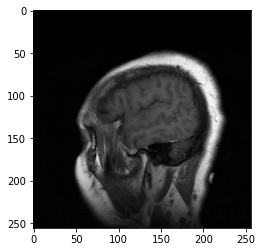

In [38]:
path = DATASET_PATH + '900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-01.dcm'
ds = dcmread(path)
plt.imshow(ds.pixel_array, cmap=plt.cm.gray)

In [39]:
type(ds)

pydicom.dataset.FileDataset

Look at the dicom files metadata.

In [40]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.50.39725992946122512731799628761000072732
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.50.39725992946122512731799628761000072732
(0008, 0020) Study Date               

Define a disease and browse through the samples using an index.

'900-00-1961'

'06-19-2005-NA-NA-04452'

'2.000000-NA-11387'

'900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-01.dcm'

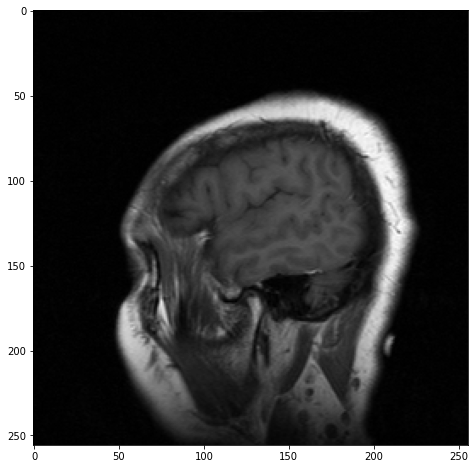

In [41]:
anim_disease = "astrocytoma"
anim_index = 1

df_anim = df[df["disease"] == anim_disease]
# only keep rows with unique instances of sample_L2
df_anim = df_anim.drop_duplicates(subset=["sample_L2"])
# sort by sample, sample_L1, sample_L2, file_name
df_anim = df_anim.sort_values(by=["sample", "sample_L1", "sample_L2"])

# make array of [sample, sample_L1, sample_L2]
df_anim_array = df_anim[
    ["sample", "sample_L1", "sample_L2", "relative_path"]
].values

display(df_anim_array[anim_index][0])
display(df_anim_array[anim_index][1])
display(df_anim_array[anim_index][2])
display(df_anim_array[anim_index][3])

# Make animation from a list of images
animation_files = df[
    (df["sample"] == df_anim_array[anim_index][0])
    & (df["sample_L1"] == df_anim_array[anim_index][1])
    & (df["sample_L2"] == df_anim_array[anim_index][2])
]["relative_path"].tolist()
animation_files = [DATASET_PATH + f for f in animation_files]

ims = []
for file in animation_files:
    ds = dcmread(file)
    ims.append(ds.pixel_array)

anim = create_animation(ims)

Look at the animation of the scan.

In [42]:
anim

## Important note!

Around this point in the process, it became clear that non of the MRI slices had any information if they contained a tumor or not. Since a scan can have the tumor only visible in, for example, 40% of the slides, 60% would be labeled without having that class feature.

While some attempts are made below to produce something useful, this can be considered the end of this notebook. To use any of the results in this notebook, a neurologist or radiologist would have to classify each MRI slice manually.

### Only keep the mid x% of sample.

In [43]:
# find number of file_names per sample + sample_L1 + sample_L2
df_size = (
    df.groupby(["sample", "sample_L1", "sample_L2"])
    .agg({"file_name": "nunique"})
    .reset_index()
)

df_size.rename(columns={"file_name": "file_count"}, inplace=True)

# add file_count column to df based on sample + sample_L1 + sample_L2
df_mid = df.merge(df_size, on=["sample", "sample_L1", "sample_L2"], how="left")


In [44]:
df_mid.head(20)

,sample,sample_L1,sample_L2,file_name,relative_path,disease,grade,label,file_count
0,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-1.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-1.dcm,astrocytoma,II,lgg,3
1,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-2.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-2.dcm,astrocytoma,II,lgg,3
2,900-00-1961,06-19-2005-NA-NA-04452,1.000000-NA-20795,1-3.dcm,900-00-1961/06-19-2005-NA-NA-04452/1.000000-NA-20795/1-3.dcm,astrocytoma,II,lgg,3
3,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-01.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-01.dcm,astrocytoma,II,lgg,16
4,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-02.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-02.dcm,astrocytoma,II,lgg,16
5,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-03.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-03.dcm,astrocytoma,II,lgg,16
6,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-04.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-04.dcm,astrocytoma,II,lgg,16
7,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-05.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-05.dcm,astrocytoma,II,lgg,16
8,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-06.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-06.dcm,astrocytoma,II,lgg,16
9,900-00-1961,06-19-2005-NA-NA-04452,2.000000-NA-11387,1-07.dcm,900-00-1961/06-19-2005-NA-NA-04452/2.000000-NA-11387/1-07.dcm,astrocytoma,II,lgg,16


In [45]:
sample_L2_start = 0
keep_percentage = 0.25
start_keep_index_sample_L2 = 0
end_keep_index_sample_L2 = 0
final_index = []

for index, row in df_mid.iterrows():
    if index == sample_L2_start:
        sample_L2_count = df_mid["file_count"].iloc[index]
        sample_L2_end = (
            sample_L2_start + sample_L2_count - 1
        )  #! something to think about?
        keep_n_sample_L2 = int(row["file_count"] * keep_percentage)
        start_keep_index_sample_L2 = (
            int((row["file_count"] - keep_n_sample_L2) / 2) + index
        )
        end_keep_index_sample_L2 = (
            start_keep_index_sample_L2 + keep_n_sample_L2 - 1
        )
        keep_sample_L2 = (
            list(
                range(start_keep_index_sample_L2, end_keep_index_sample_L2 + 1)
            )
            if keep_n_sample_L2 > 1
            else [start_keep_index_sample_L2]
        )
        sample_L2_start = sample_L2_end + 1
        final_index.extend(keep_sample_L2)

In [46]:
# only keep rows with index in final_index
df_reduced = (
    df_mid[df_mid.index.isin(final_index)]
    .reset_index(drop=True)
    .drop(columns=["file_count"])
)

In [47]:
df_reduced.groupby(["disease", "grade", "label"]).agg(
    {"sample": ["nunique", "count"]}
).reset_index()

disease grade label  sample      
                                 nunique count
0        astrocytoma    II   lgg      30  6252
1        astrocytoma   III   hgg      17  3963
2                gbm    IV   hgg      43  8098
3               none  none  none      15  4190
4  oligodendroglioma    II   lgg      11  2308
5  oligodendroglioma   III   hgg       7  1169

In [48]:
# keep 3000 samples of disease "none" and label "none"
# keep 1500 samples of disease "astrocytoma" and label "lgg"
# keep 1000 samples of disease "astrocytoma" and label "hgg"
# keep 1500 samples of disease "oligodendroglioma" and label "lgg"
# keep 1000 samples of disease "oligodendroglioma" and label "hgg"
# keep 1000 samples of disease "gbm" and label "hgg"
# keep 1000 samples of disease "gbm" and label "lgg"

display(total_samples := 9000)
display(label_split := int(total_samples / 3))
display(disease_split2 := int(label_split / 2))
display(disease_split3 := int(label_split / 3))

9000

3000

1500

1000

In [49]:
df_none = df_reduced[
    (df_reduced["disease"] == "none") & (df_reduced["label"] == "none")
][0:label_split]
df_astrocytoma_lgg = df_reduced[
    (df_reduced["disease"] == "astrocytoma") & (df_reduced["label"] == "lgg")
][0:disease_split2]
df_oligodendroglioma_lgg = df_reduced[
    (df_reduced["disease"] == "oligodendroglioma")
    & (df_reduced["label"] == "lgg")
][0:disease_split2]
df_astrocytoma_hgg = df_reduced[
    (df_reduced["disease"] == "astrocytoma") & (df_reduced["label"] == "hgg")
][0:disease_split3]
df_oligodendroglioma_hgg = df_reduced[
    (df_reduced["disease"] == "oligodendroglioma")
    & (df_reduced["label"] == "hgg")
][0:disease_split3]
df_gbm_hgg = df_reduced[
    (df_reduced["disease"] == "gbm") & (df_reduced["label"] == "hgg")
][0:disease_split3]

display(df_none.shape)
display(df_astrocytoma_lgg.shape)
display(df_oligodendroglioma_lgg.shape)
display(df_astrocytoma_hgg.shape)
display(df_oligodendroglioma_hgg.shape)
display(df_gbm_hgg.shape)

# concatenate all samples
df_reduced = pd.concat(
    [
        df_none,
        df_astrocytoma_lgg,
        df_oligodendroglioma_lgg,
        df_astrocytoma_hgg,
        df_oligodendroglioma_hgg,
        df_gbm_hgg,
    ],
    ignore_index=True,
)
display(df_reduced.shape)
df_reduced.head()

(3000, 8)

(1500, 8)

(1500, 8)

(1000, 8)

(1000, 8)

(1000, 8)

(9000, 8)

,sample,sample_L1,sample_L2,file_name,relative_path,disease,grade,label
0,HF0763,06-25-1990-NA-NA-60145,1.000000-SAG LOCAL-71958,1-08.dcm,HF0763/06-25-1990-NA-NA-60145/1.000000-SAG LOCAL-71958/1-08.dcm,none,none,none
1,HF0763,06-25-1990-NA-NA-60145,1.000000-SAG LOCAL-71958,1-09.dcm,HF0763/06-25-1990-NA-NA-60145/1.000000-SAG LOCAL-71958/1-09.dcm,none,none,none
2,HF0763,06-25-1990-NA-NA-60145,1.000000-SAG LOCAL-71958,1-10.dcm,HF0763/06-25-1990-NA-NA-60145/1.000000-SAG LOCAL-71958/1-10.dcm,none,none,none
3,HF0763,06-25-1990-NA-NA-60145,1.000000-SAG LOCAL-71958,1-11.dcm,HF0763/06-25-1990-NA-NA-60145/1.000000-SAG LOCAL-71958/1-11.dcm,none,none,none
4,HF0763,06-25-1990-NA-NA-60145,2.000000-AXIAL FSE-27407,1-039.dcm,HF0763/06-25-1990-NA-NA-60145/2.000000-AXIAL FSE-27407/1-039.dcm,none,none,none


In [50]:
display(df_reduced.shape)
df_reduced.groupby(["disease", "grade", "label"]).agg(
    {"sample": ["nunique", "count"]}
).reset_index()

(9000, 8)

disease grade label  sample      
                                 nunique count
0        astrocytoma    II   lgg      11  1500
1        astrocytoma   III   hgg       7  1000
2                gbm    IV   hgg       9  1000
3               none  none  none      13  3000
4  oligodendroglioma    II   lgg       8  1500
5  oligodendroglioma   III   hgg       7  1000

In [51]:
if not check_file_exists(DATA_PATH + VALID_SAMPLES_REDUCED_FILE):
    df_reduced.to_csv(DATA_PATH + VALID_SAMPLES_REDUCED_FILE, index=False)

/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/original_rembrandt/valid_samples_reduced.csv exists


Converting the selected images to png in a new folder structure.

In [52]:
CONVERTED_DATASET_PATH = DATA_PATH + "converted/"
dataset_converted_none = CONVERTED_DATASET_PATH + "none/none/"
dataset_converted_lgg_astrocytoma_II = (
    CONVERTED_DATASET_PATH + "lgg/astrocytoma_II/"
)
dataset_converted_lgg_oligodendroglioma_II = (
    CONVERTED_DATASET_PATH + "lgg/oligodendroglioma_II/"
)
dataset_converted_hgg_astrocytoma_III = (
    CONVERTED_DATASET_PATH + "hgg/astrocytoma_III/"
)
dataset_converted_hgg_oligodendroglioma_III = (
    CONVERTED_DATASET_PATH + "hgg/oligodendroglioma_III/"
)
dataset_converted_hgg_gbm_IV = CONVERTED_DATASET_PATH + "hgg/gbm_IV/"


In [ ]:
from skimage.transform import resize


# make list
slices = []
label_code = None

for index, row in df_reduced.iterrows():
    # convert to png. save to converted folder

    if (
        row["disease"] == "none"
        and row["grade"] == "none"
        and row["label"] == "none"
    ):
        label_code = 0
    elif (
        row["disease"] == "astrocytoma"
        and row["grade"] == "II"
        and row["label"] == "lgg"
    ):
        label_code = 1
    elif (
        row["disease"] == "oligodendroglioma"
        and row["grade"] == "II"
        and row["label"] == "lgg"
    ):
        label_code = 2
    elif (
        row["disease"] == "astrocytoma"
        and row["grade"] == "III"
        and row["label"] == "hgg"
    ):
        label_code = 3
    elif (
        row["disease"] == "oligodendroglioma"
        and row["grade"] == "III"
        and row["label"] == "hgg"
    ):
        label_code = 4
    elif (
        row["disease"] == "gbm"
        and row["grade"] == "IV"
        and row["label"] == "hgg"
    ):
        label_code = 5

    path = DATASET_PATH + row["relative_path"]
    png_path = os.path.join(
        CONVERTED_DATASET_PATH,
        row["label"],
        row["disease"],
        row["grade"],
        f"{label_code}_{index}.png",
    )

    ds = dcmread(path)
    shape = (256, 256)  # ds.pixel_array.shape
    image_2d = resize(ds.pixel_array, shape, preserve_range=True)
    # Convert to float to avoid overflow or underflow losses.
    image_2d = image_2d.astype(float)

    # Rescaling grey scale between 0-255
    image_2d_scaled = (np.maximum(image_2d, 0) / image_2d.max()) * 255.0

    # convert to uint8
    image_2d_scaled = image_2d_scaled.astype(np.uint8)

    # make folder if it does not exist
    if not os.path.exists(os.path.dirname(png_path)):
        try:
            os.makedirs(os.path.dirname(png_path))
        except OSError as exc:
            print(exc)

    # Write the PNG file
    with open(png_path, "wb") as png_file:
        w = png.Writer(shape[1], shape[0], greyscale=True)
        w.write(png_file, image_2d_scaled)

### Random samples.

In [ ]:
selection_number = 1350
lgg = int(selection_number / 2)
hgg = int(selection_number / 3)

# make a new dataframe by randomly selecting an average of 32 samples for each sample_names and reset index where disease is astrocytoma and grade "II"
df_astrocytoma_II_reduced = (
    df[(df["disease"] == "astrocytoma") & (df["grade"] == "II")]
    .sample(n=lgg, random_state=42)
    .reset_index(drop=True)
)
df_astrocytoma_III_reduced = (
    df[(df["disease"] == "astrocytoma") & (df["grade"] == "III")]
    .sample(n=hgg, random_state=42)
    .reset_index(drop=True)
)
df_oligodendroglioma_II_reduced = (
    df[(df["disease"] == "oligodendroglioma") & (df["grade"] == "II")]
    .sample(n=lgg, random_state=42)
    .reset_index(drop=True)
)
df_oligodendroglioma_III_reduced = (
    df[(df["disease"] == "oligodendroglioma") & (df["grade"] == "III")]
    .sample(n=hgg, random_state=42)
    .reset_index(drop=True)
)
df_gbm_IV_reduced = (
    df[(df["disease"] == "gbm") & (df["grade"] == "IV")]
    .sample(n=hgg, random_state=42)
    .reset_index(drop=True)
)
df_none_reduced = (
    df[(df["disease"] == "none") & (df["grade"] == "none")]
    .sample(n=selection_number, random_state=42)
    .reset_index(drop=True)
)

# combine all the dataframes
df_reduced = pd.concat(
    [
        df_astrocytoma_II_reduced,
        df_astrocytoma_III_reduced,
        df_oligodendroglioma_II_reduced,
        df_oligodendroglioma_III_reduced,
        df_gbm_IV_reduced,
        df_none_reduced,
    ]
)

display(df_astrocytoma_II_reduced.shape)
display(df_astrocytoma_III_reduced.shape)
display(df_oligodendroglioma_II_reduced.shape)
display(df_oligodendroglioma_III_reduced.shape)
display(df_gbm_IV_reduced.shape)
display(df_none_reduced.shape)
display(df_reduced.shape)

In [ ]:
df_reduced.groupby(["disease", "grade", "label"]).agg(
    {"sample": "nunique"}
).reset_index()


In [ ]:
# print number of "lgg", "hgg", "gbm" and "none" labels
df_reduced["label"].value_counts()

In [ ]:
df_count = df_reduced.copy()
df_count["count"] = 1
# get number of unique disease, grade, and label, and number of samples, and the total number of samples
df_count.groupby(["disease", "grade", "label"]).agg(
    {"sample": "nunique", "count": "count"}
).reset_index()
